In [7]:
!pip install git+https://github.com/kornia/kornia --user --upgrade
#!pip install pytorch_metric_learning

  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-mbr9urla
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-mbr9urla
  Created wheel for kornia: filename=kornia-0.4.1+0c9e625-py2.py3-none-any.whl size=206171 sha256=08a2801e03669cb42247fa83bb6b4b996230e6ec62baaca632fb7bbb1c745184
  Stored in directory: /tmp/pip-ephem-wheel-cache-yr06tdqf/wheels/5f/8b/92/375714dc479253f78ed777dd105d79f9693448dcfef85c8163
Successfully built kornia
  Found existing installation: kornia 0.4.1+0c9e625
    Uninstalling kornia-0.4.1+0c9e625:
      Successfully uninstalled kornia-0.4.1+0c9e625


In [2]:
#!pip install fastscript --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import random
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from fastai2.basics import *
from fastcore import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastprogress import fastprogress
from fastai2.callback.mixup import *
from fastscript import *
import torchvision as tv
import kornia as K
import gc
from pytorch_metric_learning import losses, miners

def imshow_torch(tensor, *kwargs):
    plt.figure()
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

In [2]:
train_ds_name = 'liberty'
val_ds_names = ['notredame', 'yosemite']

ds_root = '/home/mishkdmy/datasets/Brown/'

In [3]:
import os
import numpy as np
from PIL import Image
from typing import Any, Callable, List, Optional, Tuple, Union

import torch
import torchvision
from torchvision.datasets import VisionDataset

from torchvision.datasets.utils import download_url

from fastai2  import *


class PhotoTourRevisited(torchvision.datasets.VisionDataset):
    """`Learning Local Image Descriptors Data <http://phototour.cs.washington.edu/patches/default.htm>`_ Dataset.
    Args:
        root (string): Root directory where images are.
        name (string): Name of the dataset to load.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    urls = {
        'notredame_harris': [
            'http://matthewalunbrown.com/patchdata/notredame_harris.zip',
            'notredame_harris.zip',
            '69f8c90f78e171349abdf0307afefe4d'
        ],
        'yosemite_harris': [
            'http://matthewalunbrown.com/patchdata/yosemite_harris.zip',
            'yosemite_harris.zip',
            'a73253d1c6fbd3ba2613c45065c00d46'
        ],
        'liberty_harris': [
            'http://matthewalunbrown.com/patchdata/liberty_harris.zip',
            'liberty_harris.zip',
            'c731fcfb3abb4091110d0ae8c7ba182c'
        ],
        'notredame': [
            'http://icvl.ee.ic.ac.uk/vbalnt/notredame.zip',
            'notredame.zip',
            '509eda8535847b8c0a90bbb210c83484'
        ],
        'yosemite': [
            'http://icvl.ee.ic.ac.uk/vbalnt/yosemite.zip',
            'yosemite.zip',
            '533b2e8eb7ede31be40abc317b2fd4f0'
        ],
        'liberty': [
            'http://icvl.ee.ic.ac.uk/vbalnt/liberty.zip',
            'liberty.zip',
            'fdd9152f138ea5ef2091746689176414'
        ],
    }
    means = {'notredame': 0.4854, 'yosemite': 0.4844, 'liberty': 0.4437,
             'notredame_harris': 0.4854, 'yosemite_harris': 0.4844, 'liberty_harris': 0.4437}
    stds = {'notredame': 0.1864, 'yosemite': 0.1818, 'liberty': 0.2019,
            'notredame_harris': 0.1864, 'yosemite_harris': 0.1818, 'liberty_harris': 0.2019}
    lens = {'notredame': 468159, 'yosemite': 633587, 'liberty': 450092,
            'liberty_harris': 379587, 'yosemite_harris': 450912, 'notredame_harris': 325295}
    image_ext = 'bmp'
    info_file = 'info.txt'
    matches_files = 'm50_100000_100000_0.txt'
    img_info_files = 'interest.txt'

    def __init__(
            self, root: str, name: str, train: bool = False,
        transform: Optional[Callable] = None, download: bool = False
    ) -> None:
        super(PhotoTourRevisited, self).__init__(root)
        self.name = name
        self.data_dir = os.path.join(self.root, name)
        self.data_down = os.path.join(self.root, '{}.zip'.format(name))
        self.data_file = os.path.join(self.root, '{}.pt'.format(name))

        self.train = train
        self.mean = self.means[name]
        self.std = self.stds[name]

        if download:
            self.download()

        if not self._check_datafile_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        # load the serialized data
        self.data, self.labels, self.matches, self.img_idxs = torch.load(self.data_file)

    def __getitem__(self, index: int) -> Union[torch.Tensor, Tuple[Any, Any, torch.Tensor]]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (data1, data2, matches)
        """
        data = self.data[index]
        if self.transform is not None:
            data = self.transform(data)
        if self.train:
            return data
        return data, self.labels[index], self.img_idxs[index]

    def __len__(self) -> int:
        return self.lens[self.name]


    def _check_datafile_exists(self) -> bool:
        return os.path.exists(self.data_file)

    def _check_downloaded(self) -> bool:
        return os.path.exists(self.data_dir)

    def download(self) -> None:
        if self._check_datafile_exists():
            print('# Found cached data {}'.format(self.data_file))
            return

        if not self._check_downloaded():
            # download files
            url = self.urls[self.name][0]
            filename = self.urls[self.name][1]
            md5 = self.urls[self.name][2]
            fpath = os.path.join(self.root, filename)

            download_url(url, self.root, filename, md5)

            print('# Extracting data {}\n'.format(self.data_down))

            import zipfile
            with zipfile.ZipFile(fpath, 'r') as z:
                z.extractall(self.data_dir)

            os.unlink(fpath)

        # process and save as torch files
        print('# Caching data {}'.format(self.data_file))

        dataset = (
            read_image_file(self.data_dir, self.image_ext, self.lens[self.name]),
            read_info_file(self.data_dir, self.info_file),
            read_matches_files(self.data_dir, self.matches_files),
            read_interest_file(self.data_dir, self.img_info_files)
        )

        with open(self.data_file, 'wb') as f:
            torch.save(dataset, f)

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")


def read_image_file(data_dir: str, image_ext: str, n: int) -> torch.Tensor:
    """Return a Tensor containing the patches
    """

    def PIL2array(_img: Image.Image) -> np.ndarray:
        """Convert PIL image type to numpy 2D array
        """
        return np.array(_img.getdata(), dtype=np.uint8).reshape(64, 64)

    def find_files(_data_dir: str, _image_ext: str) -> List[str]:
        """Return a list with the file names of the images containing the patches
        """
        files = []
        # find those files with the specified extension
        for file_dir in os.listdir(_data_dir):
            if file_dir.endswith(_image_ext):
                files.append(os.path.join(_data_dir, file_dir))
        return sorted(files)  # sort files in ascend order to keep relations

    patches = []
    list_files = find_files(data_dir, image_ext)

    for fpath in list_files:
        img = Image.open(fpath)
        for y in range(0, 1024, 64):
            for x in range(0, 1024, 64):
                patch = img.crop((x, y, x + 64, y + 64))
                patches.append(PIL2array(patch))
    return torch.ByteTensor(np.array(patches[:n]))#.float()


def read_info_file(data_dir: str, info_file: str) -> torch.Tensor:
    """Return a Tensor containing the list of labels
       Read the file and keep only the ID of the 3D point.
    """
    labels = []
    with open(os.path.join(data_dir, info_file), 'r') as f:
        labels = [int(line.split()[0]) for line in f]
    return torch.LongTensor(labels)

def read_interest_file(data_dir: str, info_file: str) -> torch.Tensor:
    """Return a Tensor containing the list of image ids
       Read the file and keep only the ID of the image point.
    """
    labels = []
    with open(os.path.join(data_dir, info_file), 'r') as f:
        labels = [int(line.split()[0]) for line in f]
    return torch.LongTensor(labels)


def read_matches_files(data_dir: str, matches_file: str) -> torch.Tensor:
    """Return a Tensor containing the ground truth matches
       Read the file and keep only 3D point ID.
       Matches are represented with a 1, non matches with a 0.
    """
    matches = []
    with open(os.path.join(data_dir, matches_file), 'r') as f:
        for line in f:
            line_split = line.split()
            matches.append([int(line_split[0]), int(line_split[3]),
                            int(line_split[1] == line_split[4])])
    return torch.LongTensor(matches)

class TupleAug(ItemTransform):
    def __init__(self, tfm):
        self.tfm = tfm
    def encodes(self, o): 
        out = []
        with torch.no_grad():
            for i,oi in enumerate(o):
                if i < len(o) - 2:
                    out.append(self.tfm(oi.float().unsqueeze(1)))
                else:
                    out.append(oi)
        return out
#def average_acc_per_th(snn_ratio, is_correct, ths= np.linspace(0,1.0,20) ):
#    out = []
#    for prev_th, th in zip(ths[:-1], ths[1:]):
#        mask = snn_ratio <= th
#        #print (mask.sum())
#        AA = is_correct[mask].float().mean()
#        #print (mask.sum().item(), AA.item())
#        out.append(AA.item())
#    return out
from sklearn.metrics import average_precision_score, precision_recall_curve


'0.4.1+0c9e625'

In [4]:
torch.version.__version__

desc = K.feature.SOSNet(True)


import torch
from torch import nn
import torch.nn.functional as F

class TNet(nn.Module):
    """TFeat model definition
    """
    def __init__(self):
        super(TNet, self).__init__()
        self.features = nn.Sequential(
            nn.InstanceNorm2d(1, affine=False),
            nn.Conv2d(1, 32, kernel_size=7),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=6),
            nn.Tanh()
        )
        self.descr = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.descr(x)
        return x
    


In [5]:
!wget https://github.com/vbalnt/tfeat/raw/master/pretrained-models/tfeat-liberty.params

--2020-09-08 17:43:48--  https://github.com/vbalnt/tfeat/raw/master/pretrained-models/tfeat-liberty.params
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vbalnt/tfeat/master/pretrained-models/tfeat-liberty.params [following]
--2020-09-08 17:43:48--  https://raw.githubusercontent.com/vbalnt/tfeat/master/pretrained-models/tfeat-liberty.params
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2400533 (2.3M) [application/octet-stream]
Saving to: ‘tfeat-liberty.params’

100%[======================================>] 2,400,533   --.-K/s   in 0.1s    

2020-09-08 17:43:57 (20.5 MB/s) - ‘tfeat-liberty.params’ saved [2400533/2400533]



In [7]:
tfeat = TNet().eval()
tfeat.load_state_dict(torch.load('tfeat-liberty.params'))

<All keys matched successfully>

In [8]:
def eval_descriptor_on_dataset( desc,
    ds_name='notredame',
    resol=100,
    device=torch.device('cuda:0'),
    ds_root = '/home/mishkdmy/datasets/Brown'):
    
    desc.eval()
    desc = desc.to(device)
    dataset = PhotoTourRevisited(ds_root,
                      ds_name,
                       train=False, 
                       download=True)
    orig_size = 64
    out_size = 32
    test_aug = nn.Sequential( 
        K.Resize((out_size,out_size), interpolation='bicubic'))
    BS = 1024
    TEST_BS = 128
    N_WORKERS = 4
    
    dl_train = TfmdDL(dataset,
                 device=device,
                 after_item=[ToTensor], 
                 after_batch=[TupleAug(test_aug)], #two patches -> single tensor
                 bs=BS, num_workers=N_WORKERS,
                 shuffle = False)
    num_patches = len(dl_train.dataset)
    descriptors = []#torch.zeros(num_patches, 128)
    all_labels = []#torch.zeros(num_patches)
    all_img_labels = []#torch.zeros(num_patches)
    Miner = miners.BatchHardMiner()
    count = 0 
    max_img = -1
    min_img = 1000
    prec_per_img = []
    rec_per_img = []
    ths_per_img = []
    aps = []
    print ('Extracting descriptors and calculating AP')
    for patches, labels, img_labels in progress_bar(dl_train):
        with torch.no_grad():
            descs = desc(patches)
            descriptors.append(descs)
            all_labels.append(labels)
            all_img_labels.append(img_labels)
            all_img_labels_cat = torch.cat(all_img_labels)
            img_labels_unique = torch.sort(torch.unique(all_img_labels_cat).long())[0]
            new_max_img = img_labels_unique.max().item()
            new_min_img = img_labels_unique.min().item()
            if new_min_img != new_max_img:
                all_img_labels = torch.cat(all_img_labels)
                descriptors = torch.cat(descriptors)
                all_labels = torch.cat(all_labels)
                for ii in img_labels_unique[:-1]:
                    current_batch = all_img_labels == ii
                    cur_descs = descriptors[current_batch].cpu()
                    #print (cur_descs.shape)
                    cur_labels = all_labels[current_batch].cpu().long()
                    NN = cur_labels.size(0)
                    pos_matrix = (cur_labels[None].expand(NN,NN) == cur_labels[...,None].expand(NN,NN)) != (torch.eye(NN).to(cur_labels.device)>0)
                    #print ('pos_matrix_done')
                    neg = torch.zeros(NN).long()
                    
                    if NN > 2000: # To avoid OOM, we will find hard minimum in batches
                        bs1 = 128
                        nb = (NN // bs1)  
                        for i in range(nb):
                            st = i*bs1
                            fin = min(NN, (i+1)*bs1)
                            if fin == st:
                                break
                            dm = (torch.cdist(cur_descs[st:fin], cur_descs) +
                                  1000.0 * (pos_matrix[st:fin].to(cur_descs.dtype)) + 
                                1000.0*torch.eye(NN)[st:fin].to(cur_labels.device).to(cur_descs.dtype))
                            min_idx = torch.min(dm, dim=1)[1]
                            neg[st:fin] = min_idx       
                    #anc, pos, neg = Miner(cur_descs, cur_labels)
                    pos_idxs = torch.arange(NN)[None].expand(NN,NN)[pos_matrix]
                    anc_idxs = torch.nonzero(pos_matrix)[:,0]
                    pos_matrix = None
                    neg_idxs = neg[anc_idxs]
                    pos_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[pos_idxs])
                    neg_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[neg_idxs])
                    correct = pos_dists <= neg_dists
                    snn = torch.min(pos_dists,neg_dists) / torch.max(pos_dists,neg_dists)
                    snn[torch.isnan(snn)] = 1.0
                    #precision, recall, thresholds = precision_recall_curve(correct, 1-snn)
                    ap = average_precision_score(correct, 1-snn)
                    #prec_per_img.append(precision)
                    #rec_per_img.append(recall)
                    #ths_per_img.append(thresholds)
                    aps.append(ap)
                current_batch = all_img_labels == img_labels_unique[-1].item()
                descriptors = [descriptors[current_batch]]
                all_img_labels = [all_img_labels[current_batch]]
                all_labels = [all_labels[current_batch]]
                gc.collect()
    all_img_labels = torch.cat(all_img_labels)
    descriptors = torch.cat(descriptors)
    all_labels = torch.cat(all_labels)
    for ii in img_labels_unique:
        current_batch = all_img_labels == ii
        cur_descs = descriptors[current_batch].cpu()
        cur_labels = all_labels[current_batch].cpu()
        NN = cur_labels.size(0)
        
        pos_matrix = (cur_labels[None].expand(NN,NN) == cur_labels[...,None].expand(NN,NN)) != (torch.eye(NN).to(cur_labels.device)>0)
        #print ('pos_matrix_done')
        neg = torch.zeros(NN).long()
        if NN > 5000:
            bs1 = 128
            nb = (NN // bs1)  
            for bi in range(nb):
                st = bi*bs1
                fin = min(NN, (bi+1)*bs1)
                if fin == st:
                    break
                dm = (torch.cdist(cur_descs[st:fin], cur_descs) +
                      1000.0 * (pos_matrix[st:fin].to(cur_descs.dtype)) + 
                      1000.0*torch.eye(NN)[st:fin].to(cur_labels.device).to(cur_descs.dtype))
                min_idx = torch.min(dm, dim=1)[1]
                neg[st:fin] = min_idx       
        pos_idxs = torch.arange(NN)[None].expand(NN,NN)[pos_matrix]
        anc_idxs = torch.nonzero(pos_matrix)[:,0]
        pos_matrix = None
        neg_idxs = neg[anc_idxs]
        pos_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[pos_idxs])
        neg_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[neg_idxs])
        correct = pos_dists <= neg_dists
        snn = torch.min(pos_dists,neg_dists) / torch.max(pos_dists,neg_dists)
        snn[torch.isnan(snn)] = 1.0
        #precision, recall, thresholds = precision_recall_curve(correct, 1-snn)
        #prec_per_img.append(precision)
        #rec_per_img.append(recall)
        #ths_per_img.append(thresholds)
        ap = average_precision_score(correct, 1-snn)
        aps.append(ap)
    descriptors = None
    all_labels = None
    all_img_labels = None
    dataset=None
    dl_train = None
    gc.collect()
    return aps
    #return {"precision": prec_per_img, "recall": rec_per_img, "thresholds": ths_per_img}

    

    

from collections import defaultdict
results = defaultdict(dict) 

In [9]:
from collections import defaultdict
results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         tfeat], ['TFeat']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')


notredame
TFeat
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


/home/mishkdmy/.conda/envs/fastai1/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


TFeat mAP = 0.626
yosemite
TFeat
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


TFeat mAP = 0.731


In [10]:
!wget https://github.com/lg-zhang/dynamic-soft-margin-pytorch/raw/master/pretrained/liberty_float/model.state_dict

--2020-09-08 17:51:35--  https://github.com/lg-zhang/dynamic-soft-margin-pytorch/raw/master/pretrained/liberty_float/model.state_dict
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lg-zhang/dynamic-soft-margin-pytorch/master/pretrained/liberty_float/model.state_dict [following]
--2020-09-08 17:51:36--  https://raw.githubusercontent.com/lg-zhang/dynamic-soft-margin-pytorch/master/pretrained/liberty_float/model.state_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5347698 (5.1M) [application/octet-stream]
Saving to: ‘model.state_dict’

100%[======================================>] 5,347,698   28.7MB/s   in 0.2s   

2020-09-08 17:51

In [12]:
softmargin = K.feature.HardNet(False)
softmargin.load_state_dict(torch.load('model.state_dict'))
softmargin.eval()

HardNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): R

In [13]:
#from collections import defaultdict
#results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         softmargin], ['Dynamic SoftMargin']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')


notredame
Dynamic SoftMargin
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


Dynamic SoftMargin mAP = 0.688
yosemite
Dynamic SoftMargin
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


Dynamic SoftMargin mAP = 0.775


In [10]:
#from collections import defaultdict
#results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         K.feature.SIFTDescriptor(32, rootsift=True).to(torch.device('cuda:0')),
         K.feature.SIFTDescriptor(32, rootsift=False).to(torch.device('cuda:0')),
        K.feature.HardNet(True),
        K.feature.SOSNet(True)], ['RootSIFT', 'SIFT', 'HardNet', 'SOSNet']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')


notredame
RootSIFT
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


/home/mishkdmy/.conda/envs/fastai1/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


RootSIFT mAP = 0.579
SIFT
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


SIFT mAP = 0.569
HardNet
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


HardNet mAP = 0.686
SOSNet
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


SOSNet mAP = 0.688
yosemite
RootSIFT
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


RootSIFT mAP = 0.682
SIFT
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


SIFT mAP = 0.685
HardNet
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


HardNet mAP = 0.777
SOSNet
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


SOSNet mAP = 0.776


In [32]:
class HardNetPS(nn.Module):
    def __init__(self):
        super(HardNetPS, self).__init__()
        self.features = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1, bias = True),
        nn.BatchNorm2d(32, affine=True),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1, bias = True),
        nn.BatchNorm2d(32, affine=True),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias = True),
        nn.BatchNorm2d(64, affine=True),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, bias = True),
        nn.BatchNorm2d(64, affine=True),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2,padding=1, bias = True),
        nn.BatchNorm2d(128, affine=True),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1, bias = True),
        nn.BatchNorm2d(128, affine=True),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=8, bias = True)
    )
    def input_norm(self,x):
        flat = x.view(x.size(0), -1)
        mp = torch.mean(flat, dim=1)
        sp = torch.std(flat, dim=1) + 1e-7
        return (x - mp.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand_as(x)) / sp.unsqueeze(-1).unsqueeze(-1).unsqueeze(1).expand_as(x)

    def forward(self, input):
        x_features = self.features(self.input_norm(input))
        x = x_features.view(x_features.size(0), -1)
        return F.normalize(x, dim=1, p=2)
hnps = HardNetPS()
!wget https://github.com/DagnyT/hardnet/raw/master/pretrained/3rd_party/HardNetPS/HardNetPS.pth

--2020-09-08 18:06:05--  https://github.com/DagnyT/hardnet/raw/master/pretrained/3rd_party/HardNetPS/HardNetPS.pth
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DagnyT/hardnet/master/pretrained/3rd_party/HardNetPS/HardNetPS.pth [following]
--2020-09-08 18:06:05--  https://raw.githubusercontent.com/DagnyT/hardnet/master/pretrained/3rd_party/HardNetPS/HardNetPS.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5351453 (5.1M) [application/octet-stream]
Saving to: ‘HardNetPS.pth.1’

100%[======================================>] 5,351,453   30.4MB/s   in 0.2s   

2020-09-08 18:06:13 (30.4 MB/s) - ‘HardNetPS.pth.1’ saved [5351453/5351453

In [33]:
hnps.load_state_dict(torch.load('HardNetPS.pth'))
hnps.eval()

HardNetPS(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1,

In [34]:
#from collections import defaultdict
#results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         hnps], ['HardNetPS']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')
        break


notredame
HardNetPS
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


HardNetPS mAP = 0.592
yosemite
HardNetPS
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


KeyboardInterrupt: 

In [35]:
reslist = [ 0.569,0.579,  0.592, 0.626, 0.686, 0.688, 0.688, ]

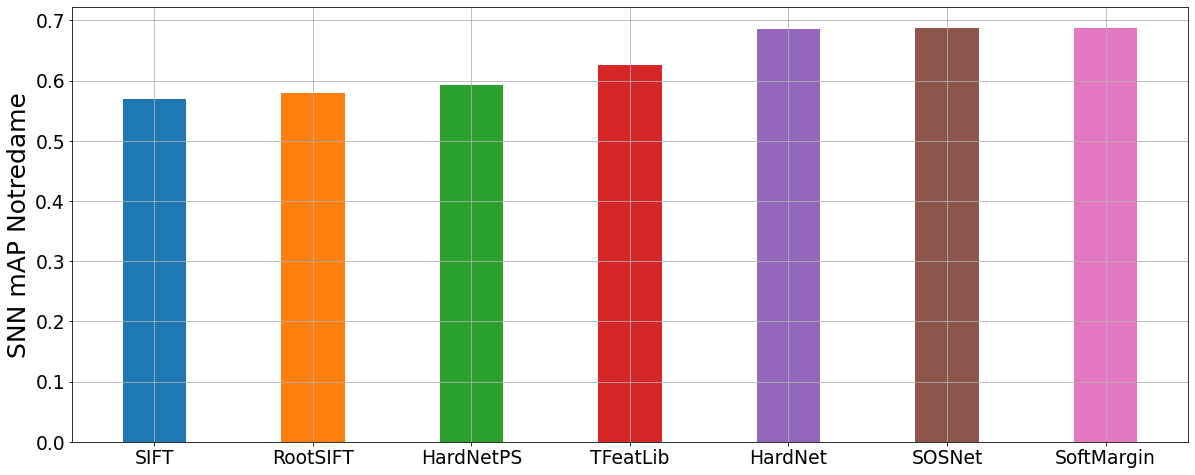

In [41]:
size=25
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

#plt.bar(np.arange(len(reslist)), reslist)
#plt.figure(figsize=(12,8))
for i in range(len(reslist)):
    plt.bar(2*i, reslist[i])
#plt.legend( ['SIFT', 'RootSIFT', 'TFeatLib', "HardNet", "SOSNet", "DynSoftMargin"])
plt.ylabel('SNN mAP Notredame')
plt.ylabel('SNN mAP Notredame')

plt.xticks(2*np.arange(len(reslist)), ['SIFT', 'RootSIFT', 'HardNetPS', 'TFeatLib', "HardNet", "SOSNet", "SoftMargin"])
#plt.legend()
plt.grid('on')

In [ ]:
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         K.feature.SIFTDescriptor(32, rootsift=True).to(torch.device('cuda:0')),
         K.feature.SIFTDescriptor(32, rootsift=False).to(torch.device('cuda:0')),
        K.feature.HardNet(True),
        K.feature.SOSNet(True)], ['RootSIFT', 'SIFT', 'HardNet', 'SOSNet']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')
